In [22]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-notebook")
%config InlineBackend.figure_format='svg'

<div>
    <div style="float:left;width:50%;text-align:center">
        <h1>pyGIMLi Tutorial @ Transform 2021</h1>
        <div>
<table style="border-collapse:collapse;border-color:#ccc;border-spacing:0" class="tg"><thead><tr><th style="background-color:#f0f0f0;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal"></th><th style="background-color:#f0f0f0;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Info</th></tr></thead><tbody><tr><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">When</td><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Monday, April 19 • 8:00 - 10:00 UTC (starts at 10.00 a.m. CET)</td></tr><tr><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Slack (Q&amp;A)</td><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;text-decoration:underline;vertical-align:top;word-break:normal"><a href="https://softwareunderground.org/">Software Underground</a> channel <a href="https://swung.slack.com/archives/C01T5V5S9EV">#t21-mon-pygimli</a></td></tr><tr><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">Live stream</td><td style="background-color:#f9f9f9;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;text-decoration:underline;vertical-align:top;word-break:normal"><a href="https://youtu.be/w3pu0H3dXe8">https://youtu.be/w3pu0H3dXe8</a></td></tr><tr><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:middle;word-break:normal">pyGIMLi documentation</td><td style="background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;text-decoration:underline;vertical-align:top;word-break:normal"><a href="https://www.pygimli.org/documentation.html">https://www.pygimli.org/documentation.html</a></td></tr></tbody></table>
        </div>
    </div>
    <div style="float:right;width:30%">
        <img src="https://www.pygimli.org/_images/pg_logo.png" alt="pyGIMLi logo">
    </div>
</div>

# Inversion with custom forward operators
### Objectives
1. Show how to use an own forward operator along with the pyGIMLi inversion

We use a modelling tool called `empymod` from Dieter Werthmüller.
The repository can be found on https://emsig.github.io/
`empymod` provides electromagnetic modelling for 1D VTI media with arbitrary transmitters and sensors in 3D space. To install it you just need to call:
```
conda install -c conda-forge empymod
```
or run it in the cell below:

In [23]:
pip install empymod

Note: you may need to restart the kernel to use updated packages.


In [24]:
import pygimli as pg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import empymod

First, we define some settings that are to be used. We assume an electric dipole transmitter perpendicular to the x-z place of length `txLen` and magnetic receivers in the air (e.g. on a drone) along a profile line. Date are obtained in frequency domain for a number of frequencies.

In [25]:
# receiver setting
rx = np.arange(50., 501., 50)
ry = np.zeros(rx.size)
# empymod arguments including transmitter
txLen = 400
inpdat = {'src': [0, 0, txLen/2, -txLen/2., 0.1, 0.1], 'strength': 1,  # ground
           'mrec': True, 'rec': [rx, ry, -20, 0, 90],  # Hz air
           # 'mrec': False, 'rec': [rx, ry, 0.1, 90, 0],  # Ey ground
          'srcpts': 11, 'htarg': {'pts_per_dec': -1}, 'verb': 1}
# frequencies
freqs = [10., 20, 50, 100, 200, 500, 1000, 2000., 5000.]  # Hz

We define a function for calling empymod with vectors of resistivity and depth.

In [26]:
def fwd(res, dep):
    """Call empymod."""
    assert len(res) == len(dep)
    OUT = np.zeros((len(freqs), len(rx)), dtype=np.complex)
    for i, f in enumerate(freqs):
        OUT[i, :] = empymod.bipole(res=np.concatenate(([2e14], res)),
                                   depth=dep, freqtime=f, **inpdat)

    return OUT

Next we create a functon to show the real and imaginary part of the data

In [27]:
def showData(A, ax=None, sym=None):
    """Show data as two subplots for real and imaginary part."""
    if ax is None:
        fig, ax = plt.subplots(1, 2)

    norm = clr.NoNorm()
    cmap = "Spectral_r"
    if sym:
        mi = np.min(np.abs(A))
        ma = np.max(np.abs(A))
        norm = clr.SymLogNorm(mi, vmin=-ma, vmax=ma)#, linscale=mi)
        cmap = 'RdBu_r'

    imr = ax[0].imshow(A.real, norm=norm, cmap=cmap)
    plt.colorbar(imr, ax=ax[0])
    imi = ax[1].imshow(A.imag, norm=norm, cmap=cmap)
    plt.colorbar(imi, ax=ax[1])
    if A.shape[1] == len(rx):
        for a in ax:
            a.xaxis.set_ticks(range(len(rx))[::3])
            a.xaxis.set_ticklabels([str(int(r)) for r in rx][::3])
            a.set_xlabel('x (m)')
            a.yaxis.set_ticks([y for y in range(len(freqs))])
            a.yaxis.set_ticklabels([str(int(f)) for f in freqs])
            a.set_ylabel('f (Hz)')

    ax[0].xaxis.set_ticks([])
    ax[0].set_xlabel('')
    ax[0].set_title("real part")
    ax[1].set_title("imaginary part")
    plt.tight_layout()
    return ax

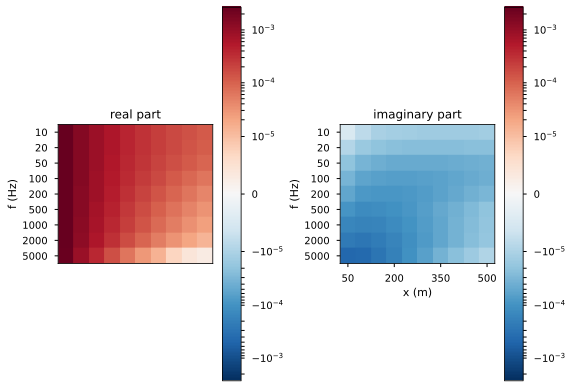

In [28]:
depth = [0, 100, 200]  # m
res = [100, 10, 100]
A0 = fwd(res, depth)
showData(A0, sym=True);

Next we create a class where we set the `response` and `createStartModel` module to invert using the forward model 

In [29]:
class myFwd(pg.Modelling):
    def __init__(self, depth):
        """Initialize the model."""
        self.dep = depth
        self.mesh1d = pg.meshtools.createMesh1D(len(self.dep))
        super().__init__()
        self.setMesh(self.mesh1d)
    
    def response(self, model):
        """Forward response."""
        A = fwd(model, self.dep)
        Avec = A.ravel()
        return np.hstack((Avec.real, Avec.imag))
        
    def createStartModel(self):
        return pg.Vector(len(self.dep)) * 100

Now we organize the real and imaginary part and add relativeError to the data

In [30]:
A0vec = A0.ravel()
data = np.hstack((A0vec.real, A0vec.imag))
# error = np.abs(data) * 0.01 + 0.00001
relativeError = np.ones_like(data) * 0.01
data *= (np.random.randn(len(data)) * relativeError + 1.0)

In [31]:
depth_fixed = np.linspace(0., 300., 21)
fop = myFwd(depth_fixed)
resistivity = np.ones_like(depth_fixed) * 100
response = fop.response(resistivity)
print(response[:20], data[:20])

[0.00268463 0.00136272 0.00083089 0.0005553  0.0003939  0.00029197
 0.00022397 0.00017662 0.00014247 0.00011711 0.00268446 0.00136239
 0.0008304  0.00055466 0.00039314 0.00029107 0.00022295 0.0001755
 0.00014125 0.00011579] [0.0026768  0.00137607 0.00082356 0.00055287 0.00039355 0.00028828
 0.00022435 0.00017611 0.00014116 0.00011346 0.00271716 0.00135071
 0.00083362 0.00055015 0.00039369 0.00028186 0.00021795 0.00016709
 0.00013372 0.00010674]


We set up the pgGIMLi inversion usng the forward operator created by `myFwd` (fop) using `setForwardOperator`

In [32]:
# from pygimli.frameworks.inversion import MeshInversion
inv = pg.Inversion()
inv.setForwardOperator(fop)
transModel = pg.trans.TransLog(1)
inv.transModel = transModel

In [33]:
model = inv.run(data, relativeError, startModel=100, verbose=True)

19/04/21 - 09:18:49 - pyGIMLi - INFO - Startmodel set from given value. 100.0
19/04/21 - 09:18:49 - pyGIMLi - INFO - Starting inversion.


fop: <__main__.myFwd object at 0x7f8b41895c70>
Data transformation: <pgcore._pygimli_.RTransLin object at 0x7f8b41895450>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x7f8b41895860>
min/max (data): -4.8e-04/0.0027
min/max (error): 1.00%/1.00%
min/max (start model): 100/100
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 92.76 (dPhi = 78.45%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 76.45 (dPhi = 18.01%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 61.92 (dPhi = 19.2%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 35.85 (dPhi = 41.71%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 

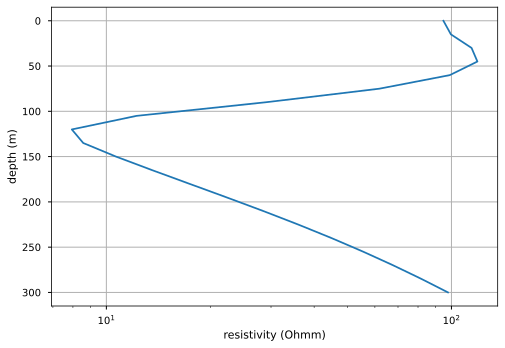

In [34]:
fig, ax = plt.subplots()
ax.semilogx(model, depth_fixed)
ax.set_ylim(ax.get_ylim()[::-1])
ax.grid(True)
ax.set_xlabel("resistivity (Ohmm)")
ax.set_ylabel("depth (m)");